## Import libraries and define global constants

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils import train_valid_model
import time
import json

MODEL_PATH = 'model/cifar10_validation.pth'
BATCH_SIZE = 4
EPOCHS = 5
DEVICE = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else "cpu"
)

## Prepare image transformation and generators 

In [2]:
transform = v2.Compose([
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = CIFAR10('data', train=True, download=False, transform=transform)
validset = CIFAR10('data', train=False, download=False, transform=transform)

In [4]:
train_dataloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(validset, BATCH_SIZE, shuffle=False, num_workers=2)

## Define model, initialize and state the forward pass

In [3]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.layer_stack = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # 32x32x3
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 32x32x64
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), # 16x16x64
      nn.BatchNorm2d(64),

      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 16x16x128
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # 16x16x128
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), # 8x8x128
      nn.BatchNorm2d(128),

      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # 8x8x256
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # 8x8x256
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), # 4x4x256
      nn.BatchNorm2d(256),

      nn.Flatten(),
      nn.Linear(4*4*256, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 10)
    )

  def forward(self, x):
    return self.layer_stack(x)

model = NeuralNetwork().to(DEVICE)
print(model)

NeuralNetwork(
  (layer_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

## Run the model on training loop with validation

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [7]:
def main():
  train_loss_history, train_accuracy_history = [], []
  valid_loss_history, valid_accuracy_history = [], []
  tik = time.time()

  for epochs in range(EPOCHS):
    train_loss, train_accuracy = train_valid_model.train(model, train_dataloader, loss_fn, optimizer, DEVICE)
    valid_loss, valid_accuracy = train_valid_model.valid(model, valid_dataloader, loss_fn, DEVICE)

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

  print(f"Training/Validation Time Elapsed: {time.time() - tik:>.3f}")
  return train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history

In [8]:
if __name__ == "__main__":
  train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = main()

Loss: 1.546800 [16000/50000]
Loss: 0.815821 [32000/50000]
Loss: 0.705295 [48000/50000]
Validation Error ----- Loss: 0.19846474 Accuracy: 72.64
Loss: 0.307185 [16000/50000]
Loss: 2.823828 [32000/50000]
Loss: 0.930701 [48000/50000]
Validation Error ----- Loss: 0.16971352 Accuracy: 77.52
Loss: 0.451557 [16000/50000]
Loss: 0.088026 [32000/50000]
Loss: 0.014230 [48000/50000]
Validation Error ----- Loss: 0.14593569 Accuracy: 80.47
Loss: 1.089047 [16000/50000]
Loss: 0.047681 [32000/50000]
Loss: 0.047814 [48000/50000]
Validation Error ----- Loss: 0.14976575 Accuracy: 81.26
Loss: 0.744535 [16000/50000]
Loss: 1.035623 [32000/50000]
Loss: 0.000014 [48000/50000]
Validation Error ----- Loss: 0.15396728 Accuracy: 81.96
Training/Validation Time Elapsed: 4164.915


## Save model and loss/accuracy history with torch and json

In [9]:
torch.save(model.state_dict(), MODEL_PATH)

In [10]:
with open("listHistory/train_l_a", 'w') as f:
  json.dump([train_loss_history, train_accuracy_history], f)

with open("listHistory/valid_l_a", 'w') as f:
  json.dump([valid_loss_history, valid_accuracy_history], f)

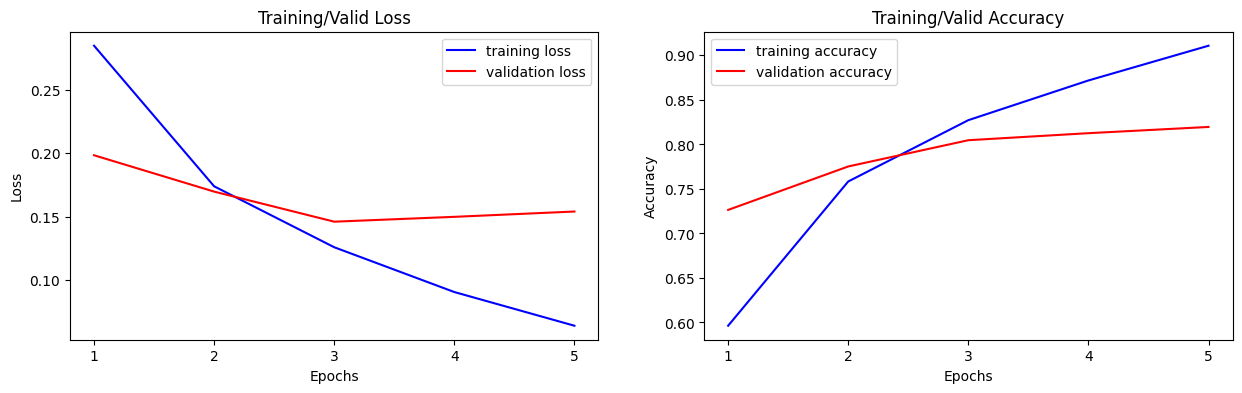

In [11]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].set_title("Training/Valid Loss")
ax[0].plot(train_loss_history, label="training loss", c='blue')
ax[0].plot(valid_loss_history, label="validation loss", c='red')
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_xticks(range(0, EPOCHS), range(1, EPOCHS+1))
ax[0].legend()

ax[1].set_title("Training/Valid Accuracy")
ax[1].plot(train_accuracy_history, label="training accuracy", c='blue')
ax[1].plot(valid_accuracy_history, label="validation accuracy", c='red')
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_xticks(range(0, EPOCHS), range(1, EPOCHS+1))
ax[1].legend()
plt.show()

## Load saved model and json history list

##### Run import libraries and cnn defition (NeuralNetwork()) only

In [4]:
model = NeuralNetwork().to(DEVICE)
model.load_state_dict(torch.load("model/cifar10_validation.pth"))

<All keys matched successfully>

In [5]:
with open("listHistory/train_l_a", "r") as f:
  train_history = json.load(f)

with open("listHistory/valid_l_a", "r") as f:
  valid_history = json.load(f)

In [9]:
train_loss, train_accuracy = train_history[0], train_history[1]
valid_loss, valid_accuracy = valid_history[0], valid_history[1]
print(f"train loss: {train_loss}\ntrain accuracy: {train_accuracy}")
print(f"valid loss: {valid_loss}\nvalid accuracy: {valid_accuracy}")

train loss: [0.2850887392269727, 0.17391456935814348, 0.12571814239267026, 0.09029510939599106, 0.06365762811297197]
train accuracy: [0.59628, 0.75834, 0.82722, 0.87182, 0.91086]
valid loss: [0.19846474047931842, 0.16971352393411127, 0.14593569033263057, 0.14976574576837445, 0.1539672788849151]
valid accuracy: [0.7264, 0.7752, 0.8047, 0.8126, 0.8196]


In [ ]:
""" 
  The model is overfitted, final epoch with 91% training accuracy and 82% validation accuracy
  - No testing statistics 
  - Deeper neural network or use resnet implementation
"""